In [1]:
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace('.', ' .')
words = text.split(' ')

# 중복은 피하고 단어마다 id를 부여하는 작업
word_to_id = {}
for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id

print(word_to_id)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


### 동시 발생 행렬
- 주변 단어들을 모두 다 세어보는 방법
- 특정 단어에 대해 그 단어의 주변에 단어가 몇 번이나 등장하는지 카운팅하여 합치는 방법

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### Co-occurrence Matrix 생성 (window size 1)
![image](./co-matrix.png)

In [3]:
# 정답 co-matrix
C = np.array([[0, 1, 0, 0, 0, 0, 0], 
              [1, 0, 1, 0, 1, 1, 0], 
              [0, 1, 0, 1, 0, 0, 0], 
              [0, 0, 1, 0, 1, 0, 0], 
              [0, 1, 0, 1, 0, 0, 0], 
              [0, 1, 0, 0, 0, 0, 1], 
              [0, 0, 0, 0, 0, 1, 0]], dtype=np.int32)

In [4]:
# ID가 0인 단어의 벡터 표현
print(C[0])
# ID가 4인 단어의 벡터 표현
print(C[4])

# "goodbye"의 벡터 표현
print(C[word_to_id['goodbye']])

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
[0 1 0 1 0 0 0]


In [5]:
# co-matrix 생성하기
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - 1
            right_idx = idx + 1

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix


In [6]:
window_size = 1
vocab_size = len(id_to_word)

C = create_co_matrix(corpus, vocab_size, window_size=1)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

### 벡터 간 유사도

단어 벡터의 유사도를 나타낼 때는 **코사인 유사도(cosine similarity)**를 자주 사용한다.  
즉, 벡터를 정규화하고 내적을 구하는 것이라고 볼 수 있다.  
코사인 유사도를 직관적으로 보면, '두 벡터가 가리키는 방향이 얼마나 비슷한가' 이다. 두 방향이 완전히 같다면 1, 반대면 -1 이 된다.  

</br>

![image](cosine_similarity.png)

In [7]:
def cos_similarity(x, y, eps=1e-8):
    # epsilon 추가
    # 0으로 나누는 것을 방지
    nx = x/np.sqrt(np.sum(x**2) + eps)
    ny = y/np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [8]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # you에 대한 단어 벡터
c1 = C[word_to_id['i']] # i에 대한 단어 벡터
print(cos_similarity(c0, c1))

0.7071067758832467


### 유사 단어의 랭킹 표시

- 검색어와 비슷한 단어를 유사도 순으로 출력하는 함수인 most_similar() 구현
1. 검색어의 단어 벡터를 꺼낸다.
2. 검색어의 단어 벡터와 다른 모든 단어 벡터와의 코사인 유사도를 각각 구한다.
3. 계산한 코사인 유사도 결과를 기준으로 값이 높은 순서대로 출력한다

In [9]:
'''
query: 비교할 단어,
word_to_id: word를 id로 인코딩한것
id_to_word: word_to_id 키, value 바꾼 것
word_matrix: co-matrix로 바꾼 것
'''

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1) 검색어의 단어 벡터 꺼내기
    if query not in word_to_id:
        print(f'{query}(을)를 찾을 수 없습니다.')
        return 
    
    print(f'\n[query] {query}')
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id] # 타겟 단어의 벡터

    # 2) 코사인 유사도 검사
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size) # 초기화 시키기
    for i in range(vocab_size):
        # 타겟 벡터와 나머지 단어 벡터들끼리 코사인 유사도 검사 
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 3) 코사인 유사도를 기준으로 내림차순으로 출력
    for i in (-1 * similarity).argsort()[:top+1]: # 내림차순으로 정렬한다는 의미
        if id_to_word[i] == query: # 타겟 단어 자기 자신이면 pass하라는 말 (유사도가 1일테니)
            continue
        print(f' {id_to_word[i]}: {similarity[i]}')

    return


In [10]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


In [11]:
# numpy의 artsort() 예시
# 오름차순
x = np.array([100, -20, 2])
x.argsort()

# 내림차순
(-x).argsort()

array([0, 2, 1])

### 통계 기반 기법 개선하기

예를 들어, Corpus에서 the와 car의 동시발생(co-occurrence)를 보면, ... the car ...라는 문구가 많이 나타날 것이다.   
the와 car의 관련성 보다 car와 drive의 관련성이 더 높지만, 동시발생 횟수로만 본다면 the와 car의 관련성이 높게 나타난다.  

이러한 문제를 해결하기 위해 점별 상호정보량(PMI, Pointwise Mutual Information)을 사용한다. PMI는 두 확률변수 x와 y에 대해 다음의 식처럼 정의 된다  

</br>

![image](pmi.png)

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>PMI</mtext>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo>,</mo>
  <mi>y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <msub>
    <mi>log</mi>
    <mrow data-mjx-texclass="ORD">
      <mn>2</mn>
    </mrow>
  </msub>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mrow data-mjx-texclass="ORD">
    <mfrac>
      <mrow>
        <mi>P</mi>
        <mo stretchy="false">(</mo>
        <mi>x</mi>
        <mo>,</mo>
        <mi>y</mi>
        <mo stretchy="false">)</mo>
      </mrow>
      <mrow>
        <mi>P</mi>
        <mo stretchy="false">(</mo>
        <mi>x</mi>
        <mo stretchy="false">)</mo>
        <mi>P</mi>
        <mo stretchy="false">(</mo>
        <mi>y</mi>
        <mo stretchy="false">)</mo>
      </mrow>
    </mfrac>
  </mrow>
  <mo>=</mo>
  <msub>
    <mi>log</mi>
    <mrow data-mjx-texclass="ORD">
      <mn>2</mn>
    </mrow>
  </msub>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mrow data-mjx-texclass="ORD">
    <mfrac>
      <mfrac>
        <mrow>
          <mi>C</mi>
          <mo stretchy="false">(</mo>
          <mi>x</mi>
          <mo>,</mo>
          <mi>y</mi>
          <mo stretchy="false">)</mo>
        </mrow>
        <mi>N</mi>
      </mfrac>
      <mrow>
        <mfrac>
          <mrow>
            <mi>C</mi>
            <mo stretchy="false">(</mo>
            <mi>x</mi>
            <mo stretchy="false">)</mo>
          </mrow>
          <mi>N</mi>
        </mfrac>
        <mfrac>
          <mrow>
            <mi>C</mi>
            <mo stretchy="false">(</mo>
            <mi>y</mi>
            <mo stretchy="false">)</mo>
          </mrow>
          <mi>N</mi>
        </mfrac>
      </mrow>
    </mfrac>
  </mrow>
  <mo>=</mo>
  <msub>
    <mi>log</mi>
    <mrow data-mjx-texclass="ORD">
      <mn>2</mn>
    </mrow>
  </msub>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mrow data-mjx-texclass="ORD">
    <mfrac>
      <mrow>
        <mi>C</mi>
        <mo stretchy="false">(</mo>
        <mi>x</mi>
        <mo>,</mo>
        <mi>y</mi>
        <mo stretchy="false">)</mo>
        <mo>&#x22C5;</mo>
        <mi>N</mi>
      </mrow>
      <mrow>
        <mi>C</mi>
        <mo stretchy="false">(</mo>
        <mi>x</mi>
        <mo stretchy="false">)</mo>
        <mi>C</mi>
        <mo stretchy="false">(</mo>
        <mi>y</mi>
        <mo stretchy="false">)</mo>
      </mrow>
    </mfrac>
  </mrow>
</math>


In [12]:
# 양의 상호정보량을 사용
def ppmi(C, verbose=False, eps=1e-8):
    '''PPMI(점별 상호정보량) 생성
    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return: ppmi
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C) # corpus 단어의 수
    S = np.sum(C, axis=0) # 각 단어의 출현 횟수
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)
            M[i, j] = max(0, pmi) # 양의 pmi로 업데이트

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print(f'{(100*cnt/total):.2f} 완료') 
    return M


In [13]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 유효자릿수 세자리로 표시
print('Co-occurrence Matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

Co-occurrence Matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 차원 축소(Dimensionality Reduction)
중요한 정보는 유지, 크기는 줄이는 것이 핵심

In [14]:
# SVD에 의한 차원 축소
%matplotlib inline
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

In [15]:
print(C[0]) # 동시발생 행렬
print(W[0]) # PPMI 행렬
print(U[0]) # SVD
# 2차원으로 차원 축소하기
print(U[0, :2])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00 -3.886e-16 -1.205e-01 -9.323e-01 -1.110e-16
  1.958e-17]
[0.341 0.   ]


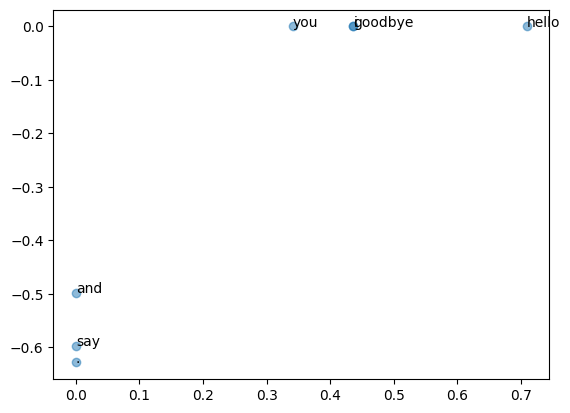

In [16]:
# matplot
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### PHB dataset

In [30]:
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

HTTPError: HTTP Error 404: Not Found